In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


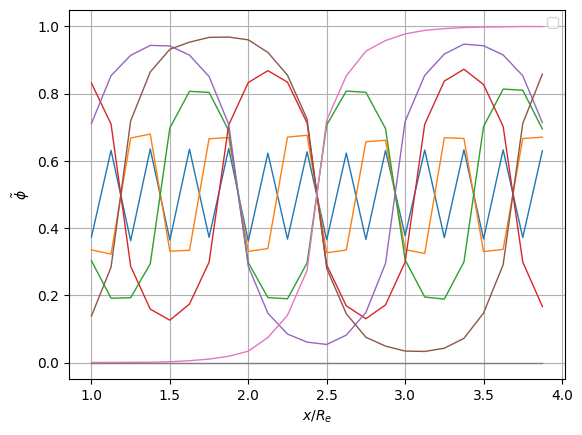

[0.94085453 0.7934473  0.49815613 0.40599622 0.24388969 0.19352806
 0.08618198 0.03328052]


In [10]:
offset=1


plt.figure(dpi=100)
plt.grid()
def plot_conversion_range(lam):
    """plot Amplitude as a function of y
    """
    dir=f"lam{lam}/Nbar100"
    with h5py.File(f'{dir}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
        with h5py.File(f'{dir}/coord_ana.h5', 'r') as f:
            #only load every other frame, the others are not optimized
            phi=np.array(f['density_field'])
    kappa=30/N
    rho0=N*n_polym/np.prod(lxyz)
    var_phi=1/(rho0*np.prod(dxyz)*kappa)
    #only every other frame is optimized
    phi=phi[1::2]
    #average phi over time
    phi=phi.mean(axis=0)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    n_cells_target=len(umb_field[umb_field>-1])
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,area51==0].reshape(phi.shape[0],nxyz[0],nxyz[1],nxyz[2])
    phi_tot=np.sum(phi,axis=0)
    #phi_tot[phi_tot==0]=1
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    composition=deepcopy(phi)
    for j in range(2):
        composition[j]/=phi_tot
    #get phi and composition at y value where umbrella field is defined averaged over z
    composition_mean=composition[:,:,0,:].mean(axis=2)
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    plt.plot(l_plot[8:-8],composition_mean[0][8:-8],lw=1)
    opt=np.loadtxt(f"{dir}/opt.csv")[1::2]
    return opt.mean()/(n_cells_target*var_phi)


opts=np.empty(0)
lams=np.array([1,2,4,5,8,10,20,40])
for lam in lams:
    opts=np.append(opts,plot_conversion_range(lam))
plt.xlabel("$x/R_e$")
plt.ylabel(r"$\tilde\phi$")
plt.legend()
#plt.savefig("amplitude_decay_profile.pdf")
plt.show()
print(opts)






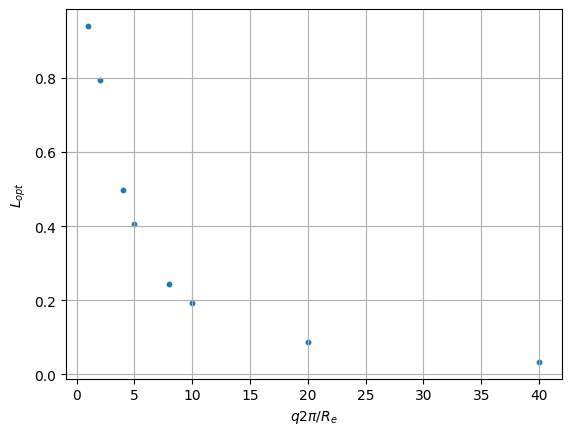

In [14]:
plt.figure(dpi=100)
plt.grid()
plt.xlabel("$\lambda/R_e$")
plt.ylabel("$L_{opt}$")
plt.scatter(lams,opts,s=10)
plt.savefig("ampltitude_decay.pdf")